In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

In [2]:
df_train = pd.read_hdf('../data/data.h5', key="train")
df_val = pd.read_hdf('../data/data.h5', key="validation")
df_test = pd.read_hdf('../data/data.h5', key="test")

In [3]:
def log_returns(series_prices):
    return np.log(series_prices).diff()

def trend(series):
    return (series[-1] - series[0]) / len(series)

def preprocess_security_daily(df):
    df = df.copy()
    
    feature_fns = [np.sum, np.mean, np.std, np.min, np.max, trend]
    
    last_days = [1, 2, 3, 4, 8, 32, 64, 128]
    cols = df.columns
    for period in last_days:
        print(period)
        for col in tqdm(cols):
            for fn in feature_fns:
                new_col_name = col + "_" + fn.__name__ + '_' + str(period)
                new_col = df[col].rolling(period).apply(fn, engine='numba', raw=True)
                df[new_col_name] = new_col.reset_index(level=0, drop=True)
    return df

In [4]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [5]:
df_train_processed = preprocess_security_daily(df_train)
df_val_processed = preprocess_security_daily(df_val)

1


100%|████████████████████████████████████████| 372/372 [00:02<00:00, 128.64it/s]


2


100%|████████████████████████████████████████| 372/372 [00:01<00:00, 231.05it/s]


3


100%|████████████████████████████████████████| 372/372 [00:02<00:00, 182.98it/s]


4


100%|████████████████████████████████████████| 372/372 [00:02<00:00, 158.04it/s]


8


100%|████████████████████████████████████████| 372/372 [00:02<00:00, 131.44it/s]


32


100%|█████████████████████████████████████████| 372/372 [00:03<00:00, 99.29it/s]


64


100%|█████████████████████████████████████████| 372/372 [00:04<00:00, 90.00it/s]


128


100%|█████████████████████████████████████████| 372/372 [00:06<00:00, 59.96it/s]


1


100%|████████████████████████████████████████| 372/372 [00:01<00:00, 320.25it/s]


2


100%|████████████████████████████████████████| 372/372 [00:01<00:00, 252.65it/s]


3


100%|████████████████████████████████████████| 372/372 [00:01<00:00, 193.61it/s]


4


100%|████████████████████████████████████████| 372/372 [00:02<00:00, 177.49it/s]


8


100%|████████████████████████████████████████| 372/372 [00:02<00:00, 133.24it/s]


32


100%|████████████████████████████████████████| 372/372 [00:03<00:00, 104.74it/s]


64


100%|█████████████████████████████████████████| 372/372 [00:03<00:00, 99.99it/s]


128


100%|█████████████████████████████████████████| 372/372 [00:04<00:00, 79.03it/s]


In [6]:
import math
df_train_processed["hour"] = df_train_processed.index.hour
df_train_processed["cos_year_day"] = np.cos(2 * math.pi * pd.Series(df_train_processed.index).dt.day_of_year / 365)
df_train_processed["sin_year_day"] = np.sin(2 * math.pi * pd.Series(df_train_processed.index).dt.day_of_year / 365)

df_train_processed["cos_year_month"] = np.cos(2 * math.pi * pd.Series(df_train_processed.index).dt.month / 12)
df_train_processed["sin_year_month"] = np.sin(2 * math.pi * pd.Series(df_train_processed.index).dt.month / 12)

df_train_processed["cos_month"] = np.cos(2 * math.pi * pd.Series(df_train_processed.index).dt.day / 30)
df_train_processed["sin_month"] = np.sin(2 * math.pi * pd.Series(df_train_processed.index).dt.day / 30)

df_train_processed["cos_week"] = np.cos(2 * math.pi * pd.Series(df_train_processed.index).dt.day_of_week / 7)
df_train_processed["sin_week"] = np.sin(2 * math.pi * pd.Series(df_train_processed.index).dt.day_of_week / 7)

In [7]:
df_val_processed["hour"] = df_val_processed.index.hour
df_val_processed["cos_year_day"] = np.cos(2 * math.pi * pd.Series(df_val_processed.index).dt.day_of_year / 365)
df_val_processed["sin_year_day"] = np.sin(2 * math.pi * pd.Series(df_val_processed.index).dt.day_of_year / 365)

df_val_processed["cos_year_month"] = np.cos(2 * math.pi * pd.Series(df_val_processed.index).dt.month / 12)
df_val_processed["sin_year_month"] = np.sin(2 * math.pi * pd.Series(df_val_processed.index).dt.month / 12)

df_val_processed["cos_month"] = np.cos(2 * math.pi * pd.Series(df_val_processed.index).dt.day / 30)
df_val_processed["sin_month"] = np.sin(2 * math.pi * pd.Series(df_val_processed.index).dt.day / 30)

df_val_processed["cos_week"] = np.cos(2 * math.pi * pd.Series(df_val_processed.index).dt.day_of_week / 7)
df_val_processed["sin_week"] = np.sin(2 * math.pi * pd.Series(df_val_processed.index).dt.day_of_week / 7)

In [16]:
df_train_processed["y"] = df_train_processed["ens_std-DEU_TEMP_EC15-12"].shift(-14)

In [17]:
model = lgb.LGBMRegressor()

In [18]:
model.fit(df_train_processed.drop("y", axis=1), df_train_processed["y"])

LGBMRegressor()

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

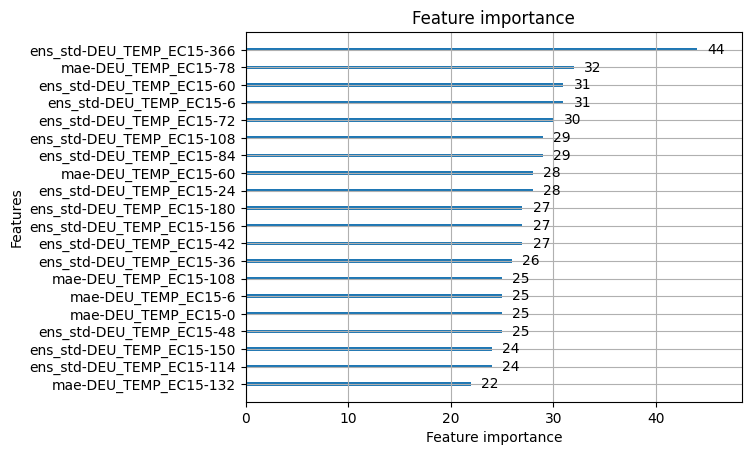

In [19]:
lgb.plot_importance(model, max_num_features=20)

In [20]:
df_val_processed["y"] = df_val_processed["ens_std-DEU_TEMP_EC15-12"].shift(-14)
if "y_hat" in df_val_processed.columns:
    df_val_processed.drop("y_hat", axis=1, inplace=True)
df_val_processed["y_hat"] = model.predict(df_val_processed.drop("y", axis=1))

<AxesSubplot: ylabel='y'>

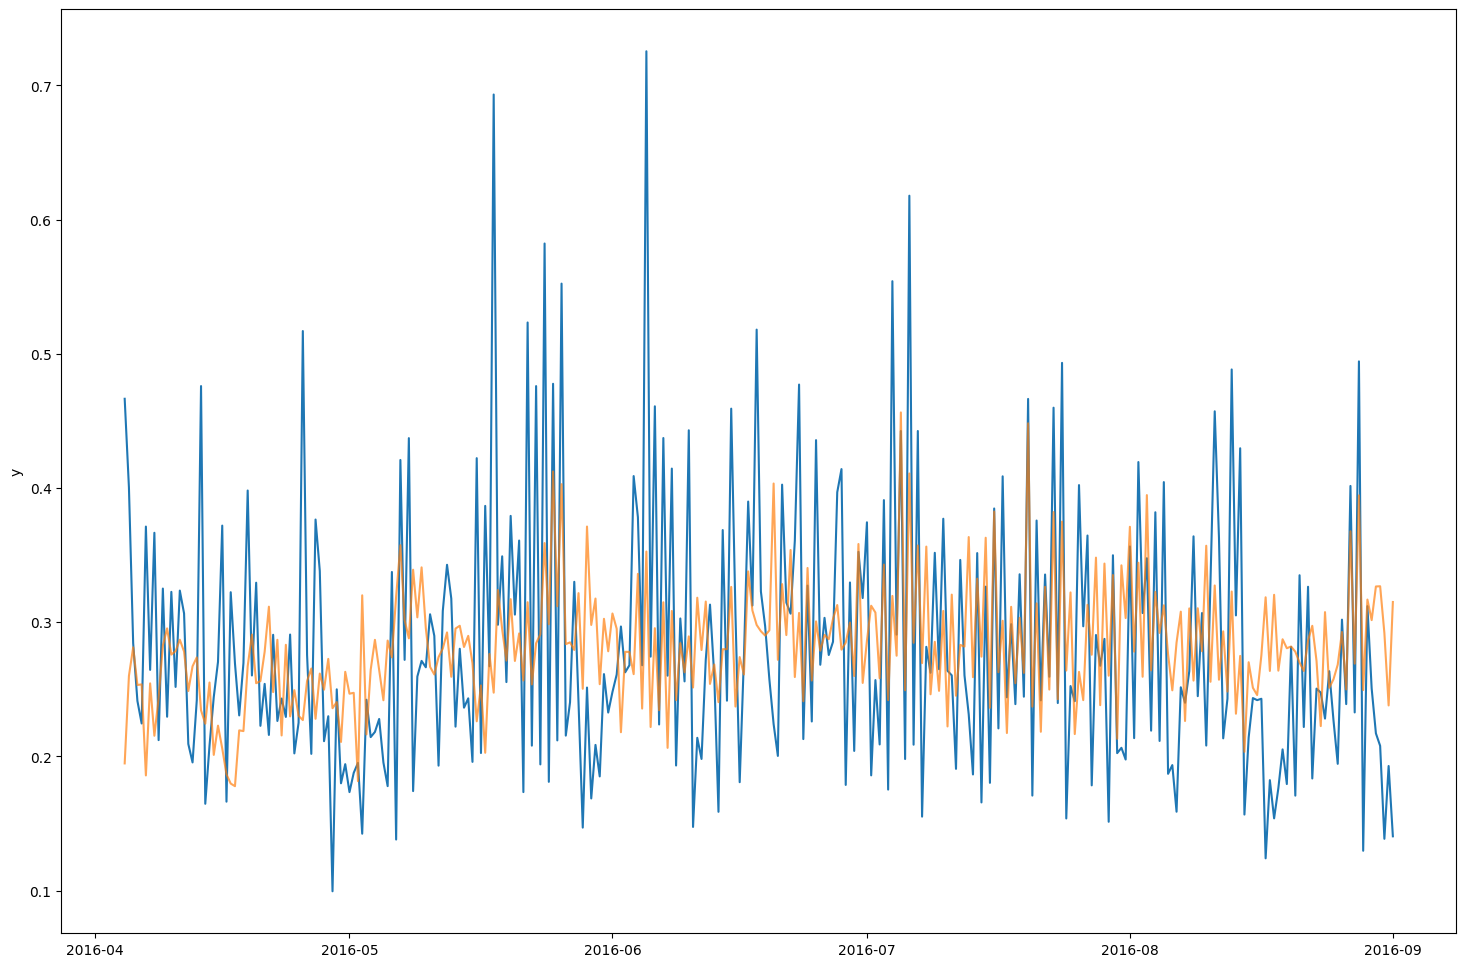

In [24]:
df_plot = df_val_processed[["y", "y_hat"]].iloc[300:600]

plt.figure(figsize=(18, 12))

sns.lineplot(data=df_plot, x=df_plot.index, y=df_plot["y"])
sns.lineplot(data=df_plot, x=df_plot.index, y=df_plot["y_hat"], alpha=0.7)

In [22]:
np.square(df_val_processed["y"] - df_val_processed["y_hat"]).mean()

0.012048942282200586

In [25]:
np.abs(df_val_processed["y"] - df_val_processed["y_hat"]).mean()

0.07977709462075333

In [23]:
df_val_processed["y"].std()

0.12647228229305246